<center>
    <u><font size="36">Hierarchical Clustering</font></u>
    <h2>by Rebecca Hinrichs</h2>
    <h4>SPRING 2023</h4>
</center>

<b>Purpose:</b> The goal of this assignment is to generate 3 Hierarchical Clustering models and choose the best solution using evaluative measures such as PCA.

<b>Data:</b> We were instructed to import the dataset `wine.csv` available in our class OneDrive folder. The data set contains 13 variables and a target variable, which we will ignore since we are working with unsupervised learning algorithms.<br>

<b>Approach:</b> We will build & train our models using `scikit-learn`'s built-in methods and optimize each model's performance using hyperparameter tuning. Finally, we will plot the best clustering solution in pairwise representation as well as dimensionality reduction using Principle Component Analysis (PCA). Lastly, we will compare the actual label groups with those predicted by our clustering model.  Our approach will consist of the following steps:
  1. EDA
  2. Modeling :: fit, tune, evaluate
     - K-Means Clustering
     - Agglomerative Clustering
     - DBSCAN
  4. Evaluation
  5. Prediction

--- -

--- 

<center><h2>1. Exploratory Data Analysis</h2></center>

---

In [1]:
## Import & Analyze the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, normalize, scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import cophenet, linkage, dendrogram
from scipy.spatial.distance import pdist

data = pd.read_csv('wine.csv')
display(data)

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [2]:
y = data['Wine']
X = data.drop('Wine', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic.acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Acl                   178 non-null    float64
 4   Mg                    178 non-null    int64  
 5   Phenols               178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid.phenols  178 non-null    float64
 8   Proanth               178 non-null    float64
 9   Color.int             178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD                    178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [3]:
X.isna().sum().sum()

0

--- 

<center><h2>2. Modeling</h2></center>

---

> k-Means Clustering

In [4]:
## Preprocess the data
X_scaled = MinMaxScaler().fit_transform(X)  # scale numerical columns by their relative columns
display(X_scaled)

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

In [5]:
## First we'll use Dr. Jegdic's functions because we ♥ them but NOTE these work for 2 variables only
def distance(i, X, centroid):
    return np.sqrt(sum((X[i, j] - centroid[j])**2 for j in range(2)))
def assign_label(i, X, centroids):
    distances = np.array([distance(i, X, centroid) for centroid in centroids])
    label = np.argmin(distances)
    return label 
def assign_clusters(X, centroids):
    return [assign_label(i, X, centroids) for i in range(len(X))]
def update_centroids(X, centroids):
    current_labels = assign_clusters(X, centroids)
    k = len(centroids)
    centroid_means = {i : [0, 0] for i in range(k)}
    for i in range(len(X)):
        centroid_means[current_labels[i]][0] += X[i, 0]
        centroid_means[current_labels[i]][1] += X[i, 1]
    for i in range(k):
        num_occur = current_labels.count(i)
        centroid_means[i][0] = centroid_means[i][0]/num_occur
        centroid_means[i][1] = centroid_means[i][1]/num_occur
    return [(centroid_means[i][0], centroid_means[i][1]) for i in centroid_means]
def k_means_clustering(X, k, max_iter = 100):
    centroids = []
    for j in range(k):
        i = np.random.randint(0, int(X.shape[0])-1)
        point = (X.iloc[i, 0], X.iloc[i, 1], j)
        centroids.append(point)
    for _ in range(max_iter):
        centroids = update_centroids(X, centroids)
    return centroids
def show_k_clusters(X):  # <<--- my contribution
    col1 = int(input(f'\nEnter the index of the first variable:\n'))
    col2 = int(input(f'\nEnter the index of the second variable:\n'))
    k = int(input(f'\nEnter the number of clusters:\n'))
    X = pd.DataFrame(X[:,col1], X[:,col2])
    centroids = k_means_clustering(X, k)
    current_labels = assign_clusters(X, centroids)
    current_colors = [colors(label) for label in current_labels]
    plt.figure(figsize=(8,6))
    plt.scatter(X.iloc[:,col1], X.iloc[:,col2], c=current_colors, s=10)
    plt.xlabel(f'{data.columns[col1]}', fontsize=15)
    plt.ylabel(f'{data.columns[col2]}', fontsize=15)
    plt.show();
# show_k_clusters(X_scaled)  # sample of 'k' clusters choosing 2 variables  ## <<<--- NEEDING np/pd conversions

In [6]:
## Instantiate & Fit the Model
import warnings
warnings.filterwarnings("ignore")  # <<-- to suppress version deprecation warnings
k = np.random.randint(0, data.shape[1])  # a random number for 'k'
km_model = KMeans(n_clusters=k).fit(X_scaled)
print(f'\nk-Means Clustering\n\t\tNumber of Clusters :: {len(km_model.cluster_centers_)}\n'
      f'\t\tCluster/Label Values :: {[c for c in set(km_model.labels_)]}\n'
      f'\t\tCentroid Cardinality :: {len(km_model.cluster_centers_[0])}\n'
      f'\t\tCentroid Locations ::\n\n{km_model.cluster_centers_}\n'
      f'\n\tClustering Performance...\n'
      f'\t\tWithin-Cluster Variation (centroid tightness) :: {round(km_model.inertia_, 4)}\n'
      f'\t\tTransformation Matrix A has shape :: {km_model.transform(X_scaled).shape}\n'
      f'\t\tModel Silhouette Score :: {round(silhouette_score(X_scaled, km_model.labels_), 4)}\n')


k-Means Clustering
		Number of Clusters :: 9
		Cluster/Label Values :: [0, 1, 2, 3, 4, 5, 6, 7, 8]
		Centroid Cardinality :: 13
		Centroid Locations ::

[[0.76673684 0.20403162 0.59700535 0.31670103 0.38173913 0.68496552
  0.60481013 0.32528302 0.52744479 0.43952218 0.51869919 0.61992674
  0.73029957]
 [0.28512586 0.20347139 0.55056963 0.55378754 0.22258979 0.32698651
  0.28416804 0.67350287 0.28775202 0.13963496 0.49650053 0.44688645
  0.17527755]
 [0.5389016  0.62502148 0.56498489 0.55289108 0.2594518  0.22998501
  0.0673271  0.70549631 0.18090797 0.37334916 0.2078473  0.20640229
  0.24151833]
 [0.49921053 0.15118577 0.50802139 0.33453608 0.50108696 0.46517241
  0.41793249 0.33396226 0.49053628 0.21493174 0.53902439 0.51648352
  0.47631954]
 [0.61176471 0.40339456 0.5608682  0.53305033 0.29731458 0.2801217
  0.0907173  0.68923418 0.321581   0.69549287 0.1300813  0.13940961
  0.27078963]
 [0.37581454 0.16205534 0.31830914 0.40672558 0.20238095 0.39934319
  0.33986337 0.32973944 0.323

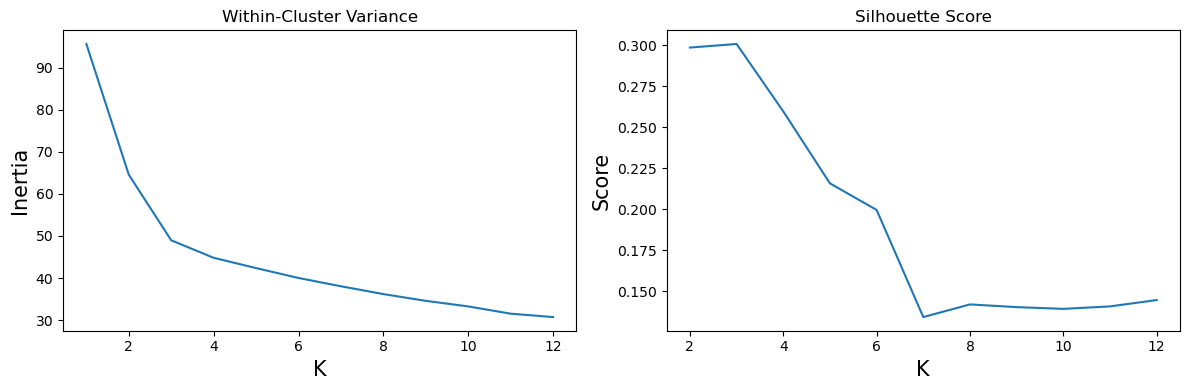

In [7]:
## Optimize the Model using Hyperparameter Tuning
inertias, silhouettes = list(), list()
for k in range(1, int(X.shape[1])):
    km = KMeans(n_clusters=k)  # uses k-means++ like our original
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    if k > 1:
        silhouettes.append(silhouette_score(X_scaled, km.labels_))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Minimizing the Within-Cluster Variance
axes[0].plot(range(1, int(X.shape[1])), inertias)
axes[0].set_xlabel('K', fontsize=15)
axes[0].set_ylabel('Inertia', fontsize=15)
axes[0].set_title('Within-Cluster Variance')

# Maximizing the Silhouette Score
axes[1].plot(range(2, int(X.shape[1])), silhouettes)
axes[1].set_xlabel('K', fontsize=15)
axes[1].set_ylabel('Score', fontsize=15)
axes[1].set_title('Silhouette Score')
plt.tight_layout()
plt.show();

The 'elbow' given by the `Within-Cluster Variance` graph suggests that our best value for $k$- indicated by the greatest change in slope- should be a value around $k=3$, where $\Delta \frac{dx}{dy}$ shows the greatest shift. This indicates $3$ as our strongest suitor for an optimal $k$ value. To confirm, we plotted the `Silhouette Score` values given by each $k$ and observe the maximum point along the slope to be given by the value $k=3$, whereby all values of $k$ thereafter decrease significantly. Given these tests, we can conclude $k=3$ is indeed our best choice to minimize variance within each cluster and to maximize distance between the clusters. We will provide one last test to indicate the quality of our clustering solution (the combination of tightness and distinction of clusters) using a *Silhouette Visualizer*.


k-Means Clustering
		Number of Clusters :: 3
		Cluster/Label Values :: [0, 1, 2]
		Centroid Cardinality :: 13
		Centroid Locations ::

[[0.70565142 0.24842869 0.58490401 0.3444313  0.41072701 0.64211419
  0.55467939 0.30034024 0.47727155 0.35534046 0.47780888 0.69038612
  0.59389397]
 [0.54668616 0.48440931 0.56159636 0.53865979 0.31521739 0.2467433
  0.10474293 0.61425577 0.22543521 0.48878144 0.18888889 0.15852666
  0.24911502]
 [0.31336675 0.23561704 0.47304983 0.50024546 0.24551415 0.44805692
  0.38008171 0.41868823 0.39717591 0.14778699 0.47218996 0.58422001
  0.15637525]]

	Clustering Performance...
		Within-Cluster Variation (centroid tightness) :: 48.954
		Transformation Matrix A has shape :: (178, 3)
		Model Silhouette Score :: 0.3013




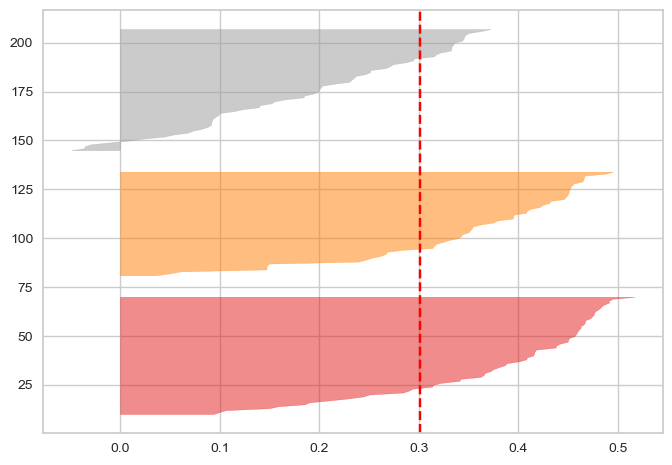

In [8]:
## Evaluate the Model's Performance (quality of clustering solutions)
k = 3   # optimal 'k' from visual analysis
km_model = KMeans(n_clusters=k).fit(X_scaled)
print(f'\nk-Means Clustering\n\t\tNumber of Clusters :: {len(km_model.cluster_centers_)}\n'
      f'\t\tCluster/Label Values :: {[c for c in set(km_model.labels_)]}\n'
      f'\t\tCentroid Cardinality :: {len(km_model.cluster_centers_[0])}\n'
      f'\t\tCentroid Locations ::\n\n{km_model.cluster_centers_}\n'
      f'\n\tClustering Performance...\n'
      f'\t\tWithin-Cluster Variation (centroid tightness) :: {round(km_model.inertia_, 4)}\n'
      f'\t\tTransformation Matrix A has shape :: {km_model.transform(X_scaled).shape}\n'
      f'\t\tModel Silhouette Score :: {round(silhouette_score(X_scaled, km_model.labels_), 4)}\n\n')
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(km_model)
visualizer.fit(X_scaled);

The visualizer tells us that of our 3 clusters, one cluster has a few misclassified data points in the first (blue) cluster. Otherwise, the remaining (orange & red) clusters indicate very similar silhouette coefficient values. These coefficients, when classified correctly, range in value from (0,1] to indicate their clustering quality; a coefficient close to 1 indicates that the data point is well-defined by its determining centroid and far away from neighboring clusters, while a coefficient close to 0 indicates the point is near the decision boundary between two clusters. By the 'blades' in our graph being fairly similar in reach, with near-centroid coefficients ranging approximately (0.35, 0.5) we see our best average of 0.3 is met by all 3 clusters.

> Agglomerative Clustering

In [9]:
## Preprocess the data
X_scaled2 = scale(X, axis=0)  # scale columns independently, centering mean & scaling to unit variance per feature
display(X_scaled2)

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

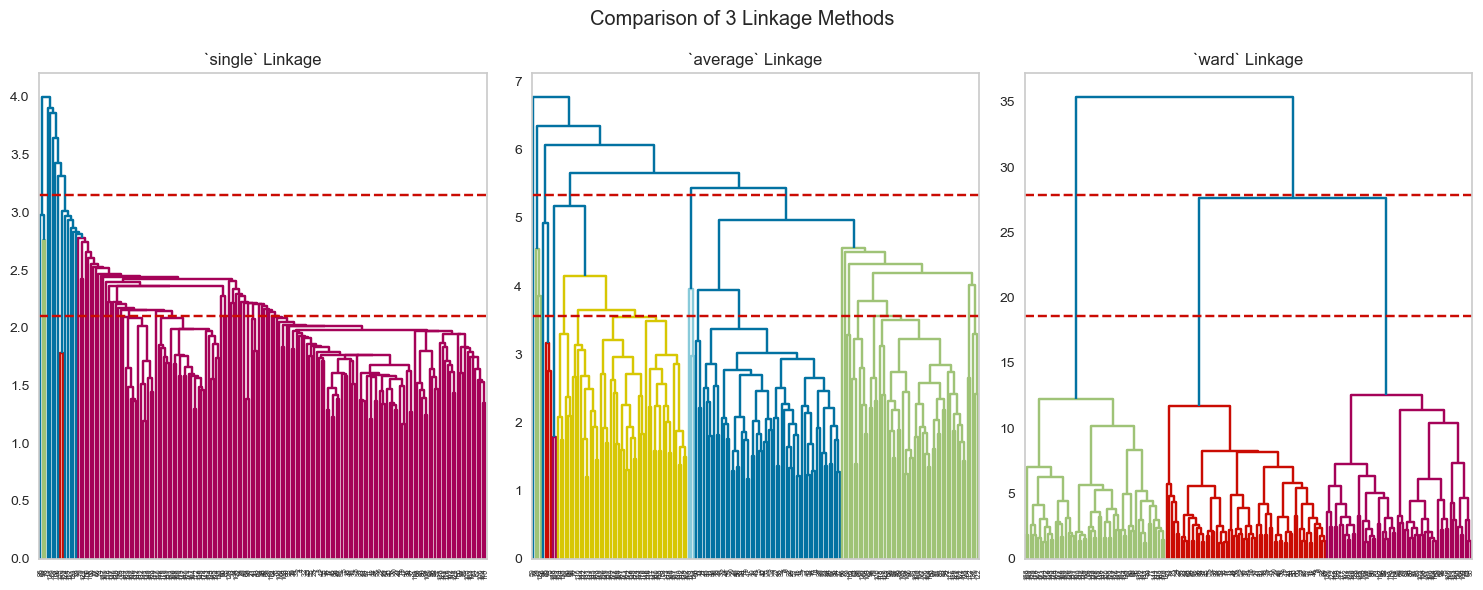

In [10]:
## Optimize the Model using Hyperparameter Tuning
linkage_methods = ['single','average','ward'] # find the best linkage method
fig, axes = plt.subplots(1,3,figsize=(15,6))
for i, (ax, method) in enumerate(zip(axes, linkage_methods)):
    dendrogram(linkage(X_scaled2, method=method), ax=ax)
    ax.axhline(y=ax.get_ylim()[1]*.75, color='r', linestyle='--') # 3rd quartile
    ax.axhline(y=ax.get_ylim()[1]*.5, color='r', linestyle='--') # median
    ax.set_title(f'`{method}` Linkage')
    ax.grid();
plt.suptitle("Comparison of 3 Linkage Methods")
plt.tight_layout()
plt.show();

In [267]:
## Instantiate & Fit the Model
k_opt = 3   # optimal number of 'k' we found from our dendogram
agg_model = AgglomerativeClustering(n_clusters=k_opt, 
                                    affinity='euclidean', # default: distance btwn pts
                                    linkage='ward').fit(X_scaled2)  # optimal linkage method
print(f'\nAgglomerative Clustering\n\t\tNumber of Clusters :: {agg_model.n_clusters_}\n'
      f'\t\tCluster/Label Values :: {[c for c in set(agg_model.labels_)]}\n')


Agglomerative Clustering
		Number of Clusters :: 3
		Cluster/Label Values :: [0, 1, 2]



In [12]:
## Evaluate the Model's Performance (quality of clustering solutions)
coph_coeff = cophenet(linkage(X_scaled2, method='ward'), pdist(X_scaled2))
print(f'\n\tClustering Performance...\n'
      f'\t\tAverage Silhouette Coefficients :: {round(silhouette_score(X_scaled2, agg_model.labels_), 4)}\n'
      f'\t\tModel Cophenetic Score :: {np.round(coph_coeff[0], 4)}\n' # (0,1): 1 if physical distance == dendogram distance
      f'\t\tPhysical Distance Vector ::\n\n\t{np.round(coph_coeff[1], 4)}\n\n')  # euclidean distance btwn pts


	Clustering Performance...
		Average Silhouette Coefficients :: 0.2774
		Model Cophenetic Score :: 0.6623
		Physical Distance Vector ::

	[5.7959 8.2534 8.1374 ... 1.8262 6.2647 6.2647]




First, we evaluated our linkage metrics in order to choose the optimal approach. We compared the horizontal spread of the chaining trees to determine the best linkage method. From there, we were able to find our optimal value for $k$ based on our optimal linkage metric. Using the Cophenetic Coefficients measuring the correlation of the features' distances physically vs those returned by the dendogram, we achieved a score of $.66$.

> DBSCAN

In [217]:
## Preprocess the data
X_normalized = normalize(X, norm='max', axis=1)  # since we want densities now instead of distances
display(X_normalized)

array([[1.33615023e-02, 1.60563380e-03, 2.28169014e-03, ...,
        9.76525822e-04, 3.68075117e-03, 1.00000000e+00],
       [1.25714286e-02, 1.69523810e-03, 2.03809524e-03, ...,
        1.00000000e-03, 3.23809524e-03, 1.00000000e+00],
       [1.11054852e-02, 1.99156118e-03, 2.25316456e-03, ...,
        8.69198312e-04, 2.67510549e-03, 1.00000000e+00],
       ...,
       [1.58922156e-02, 5.12574850e-03, 2.70658683e-03, ...,
        7.06586826e-04, 1.86826347e-03, 1.00000000e+00],
       [1.56785714e-02, 3.08333333e-03, 2.82142857e-03, ...,
        7.14285714e-04, 1.92857143e-03, 1.00000000e+00],
       [2.52321429e-02, 7.32142857e-03, 4.89285714e-03, ...,
        1.08928571e-03, 2.85714286e-03, 1.00000000e+00]])

In [231]:
## Instantiate & Fit the Model
eps = np.random.uniform(0.0001, 0.99)  # a random number for 'eps'
min_samples = np.random.randint(1, int(X.shape[1]))  # random number of pts per neighborhood
db_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X_normalized)
db_nbrs = np.unique(db_model.labels_, return_counts=True)[1]
while len(set(db_model.labels_)) < 2:
    eps = np.random.uniform(0.0001, 0.99)  # a random number for 'eps'
    min_samples = np.random.randint(1, int(X.shape[1]))  # random number of pts per neighborhood
    db_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X_normalized)
    db_nbrs = np.unique(db_model.labels_, return_counts=True)[1]
print(f'\nDensity-Based Spatial Clustering of Applications (DBSCAN)\n'
      f'\t\tNumber of Clusters :: {len(set(db_model.labels_))}\n'
      f'\t\tCluster/Label Values ::\n\t{[c for c in set(db_model.labels_)]}\n'
      f'\t\tSize of Neighborhood per Value ::\n\t{[s for s in db_nbrs]}\n\n')
db_model.get_params()


Density-Based Spatial Clustering of Applications (DBSCAN)
		Number of Clusters :: 3
		Cluster/Label Values ::
	[0, 1, -1]
		Size of Neighborhood per Value ::
	[40, 131, 7]




{'algorithm': 'auto',
 'eps': 0.010742338305650375,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 7,
 'n_jobs': None,
 'p': None}

In [233]:
np.unique(X_val)

array([0, 1, 2], dtype=int64)

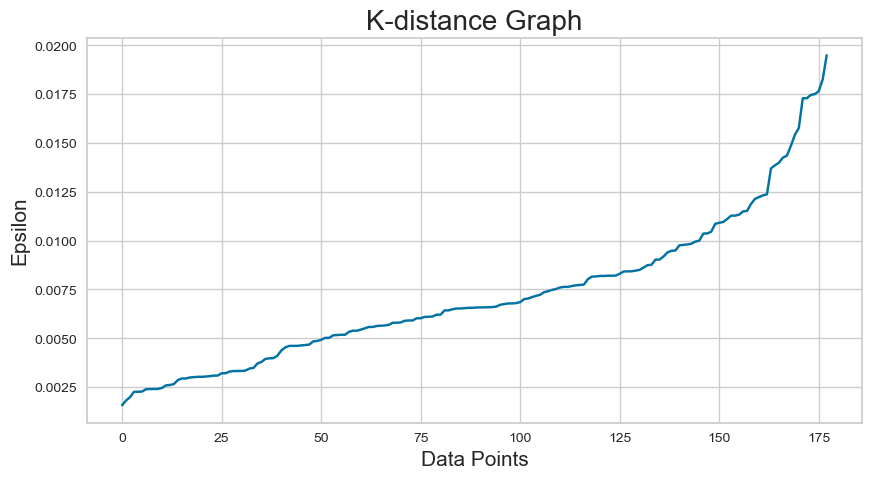

In [234]:
## Optimize the Model using Hyperparameter Tuning
X_val = y.to_numpy().reshape(-1,1)
# 1- Find the optimal 'min_samples' value
from sklearn.metrics import davies_bouldin_score  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
min_samples_opt, sil_score_opt, db_score_opt = 0, -1, float('inf')
for min_samples in range(2, 7):
    db_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X_normalized)
    sil_score = silhouette_score(X_val, db_model.labels_)
    db_score = davies_bouldin_score(X_val, db_model.labels_)
    if sil_score > sil_score_opt:
        sil_score_opt = sil_score
        min_samples_opt = min_samples
    if db_score < db_score_opt:
        db_score_opt = db_score
        min_samples_opt = min_samples

# 2- Find the optimal 'eps' value
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=min_samples_opt)
nbrs = neigh.fit(X_normalized)
distances, indices = nbrs.kneighbors(X_normalized)
dist = np.sort(distances[:,2])
plt.figure(figsize=(10,5))
plt.plot(dist)
plt.title("K-distance Graph",fontsize=20)
plt.xlabel("Data Points",fontsize=15)
plt.ylabel("Epsilon",fontsize=15);

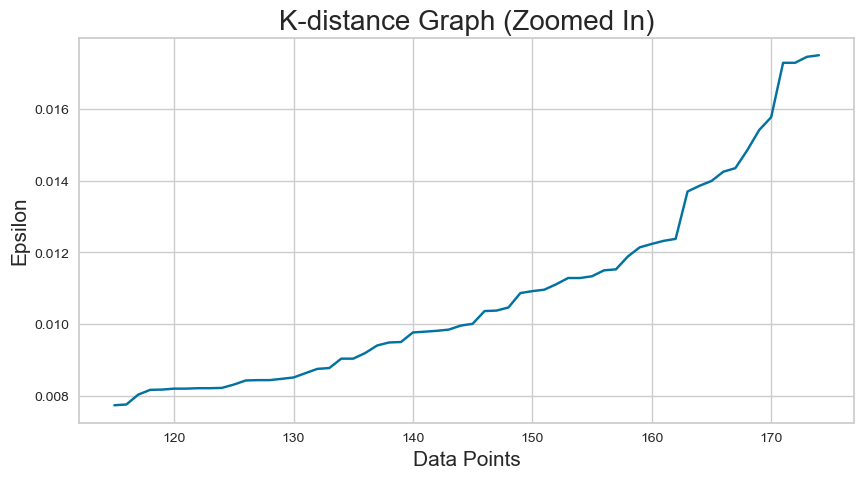

In [235]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(115,175), dist[115:175])  # zoom in on elbow
plt.title("K-distance Graph (Zoomed In)",fontsize=20)
plt.xlabel("Data Points",fontsize=15)
plt.ylabel("Epsilon",fontsize=15);

In [236]:
min_samples_opt

5

In [266]:
## Evaluate the Model's Performance (quality of clustering solutions)
eps_opt = 0.011   # optimal 'eps' from visual analysis
min_samples = min_samples_opt  # based on our result from the Davies-Bouldin Score
db_model = DBSCAN(eps=eps_opt, min_samples=min_samples).fit(X_normalized)
db_nbrs = np.unique(db_model.labels_, return_counts=True)[1]
print(f'\nDensity-Based Spatial Clustering of Applications (DBSCAN)\n'
      f'\t\tNumber of Clusters :: {len(set(db_model.labels_))}\n'
      f'\t\tCluster/Label Values ::\n\t{[c for c in set(db_model.labels_)]}\n'
      f'\t\tSize of Neighborhood per Value ::\n\t{[s for s in db_nbrs]}\n\n')


Density-Based Spatial Clustering of Applications (DBSCAN)
		Number of Clusters :: 3
		Cluster/Label Values ::
	[0, 1, -1]
		Size of Neighborhood per Value ::
	[31, 134, 13]




We found our optimal $\epsilon$- which is the most significant parameter of the DBSCAN model- to be approximately $\epsilon=0.36$. This hyperparameter sets the proximity metric of determing the allowed chaining of data points into a cluster (neighborhood). We were also able to find the optimal number of minimum samples to include in a neighborhood (the 'districting' factor) using the Davies-Bouldin scoring index, also available in `sklearn`. Using a combination of the scoring with silhouette scoring against the previous model, we were able to find the optimal `min_samples` hyperparameter as well.<br>

--- 

<center><h2>3. Evaluation</h2></center>

---

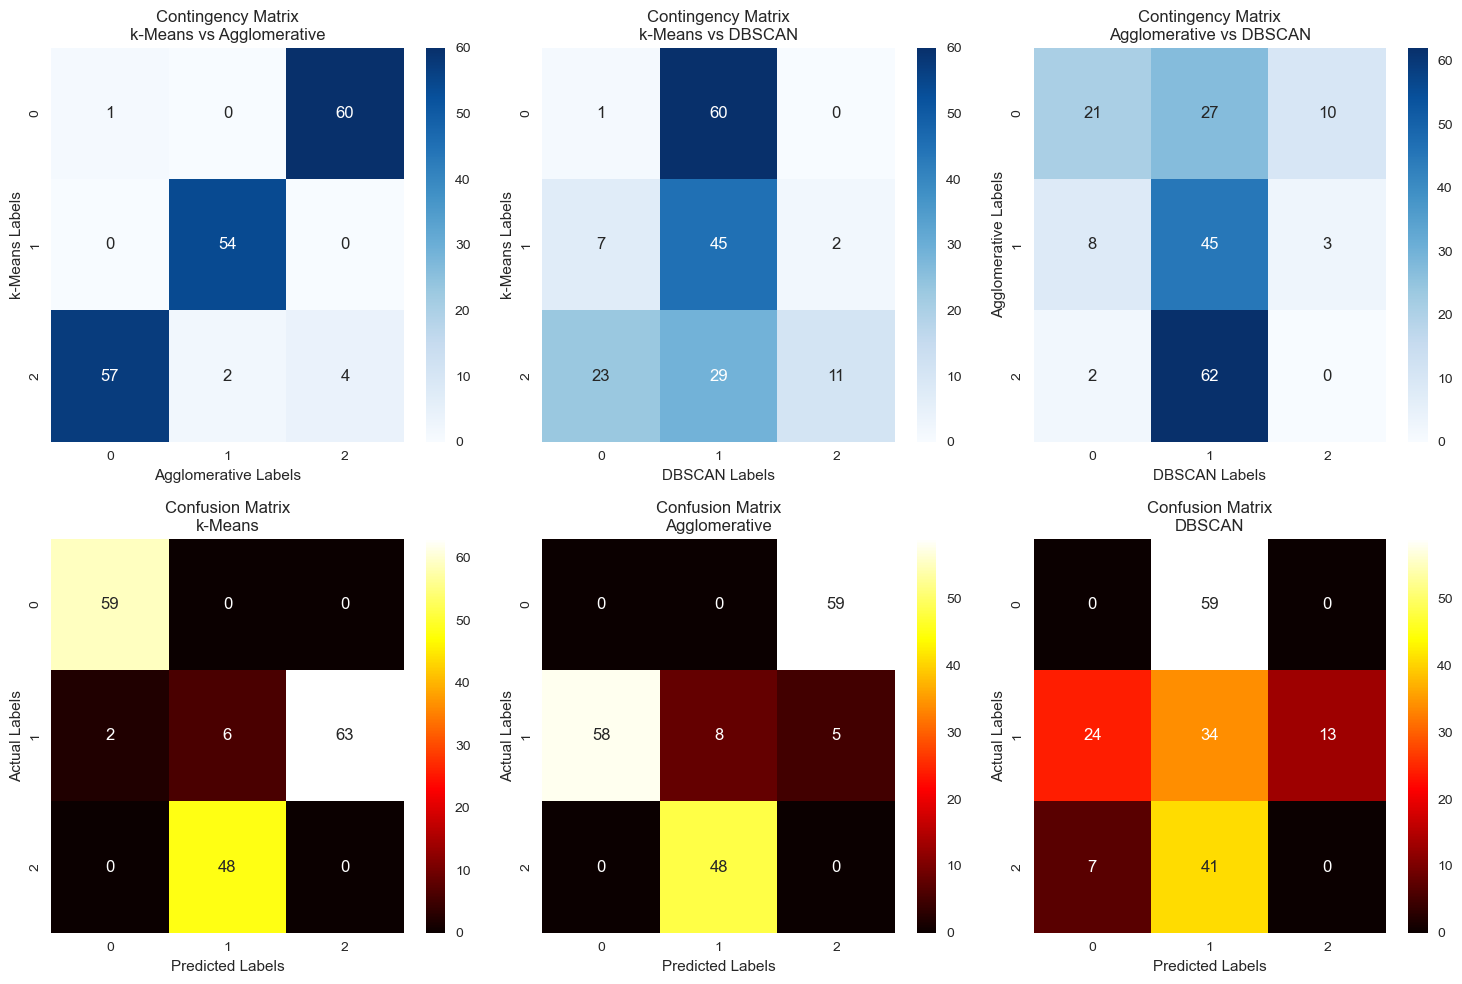

In [242]:
## Plot the best clustering solution in pairwise representation
db_labels = db_model.labels_ + 1
import seaborn as sns
cm_km_agg = contingency_matrix(km_model.labels_, agg_model.labels_)
cm_km_db = contingency_matrix(km_model.labels_, db_labels)
cm_agg_db = contingency_matrix(agg_model.labels_, db_labels)
models = ['k-Means','Agglomerative','DBSCAN']
pred_labels = [km_model.labels_, agg_model.labels_, db_labels]
cont_matrices = [cm_km_agg, cm_km_db, cm_agg_db]
fig, axes = plt.subplots(2,3, figsize=(15,10))
for i, labels in enumerate(pred_labels):
    if i==0: cont_mtx, mtx1, mtx2 = cont_matrices[i], models[i], models[i+1]
    if i==1: cont_mtx, mtx1, mtx2 = cont_matrices[i], models[i-1], models[i+1]
    if i==2: cont_mtx, mtx1, mtx2 = cont_matrices[i], models[i-1], models[i]
    sns.heatmap(cont_mtx, annot=True, cmap='Blues', fmt='d', ax=axes[0,i])
    axes[0,i].set_title(f'Contingency Matrix\n{mtx1} vs {mtx2}')
    axes[0,i].set_xlabel(f'{mtx2} Labels')
    axes[0,i].set_ylabel(f'{mtx1} Labels')      
    conf_mtx = contingency_matrix(y, labels)
    sns.heatmap(conf_mtx, annot=True, cmap='hot', fmt='d', ax=axes[1,i])
    axes[1,i].set_title(f'Confusion Matrix\n{models[i]}')
    axes[1,i].set_xlabel(f'Predicted Labels')
    axes[1,i].set_ylabel(f'Actual Labels')
plt.tight_layout()
plt.show();

The blue plots show the comparative measures of the models against each other. Darker blues represent higher quantities. `kMeans` and `AgglomerativeClustering` appear to represent the most similarity in classification labels. This is expected, since both algorithms rely on Euclidean distance measurements. `DBSCAN`'s grouping mechanism relies on its determination of a data point's eligibility to belong to a cluster based on its density relationship to surrounding points.<br><br>
In the bottom row, the brighter boxes represent higher counts and the darker boxes lower counts. These boxes suggest that our most accurate predictions may belong to `kMeans` with 8 misclassifications, followed by `Agglomerative` with 13 misclassifications. Our `DBSCAN` model performed the worst with over 30 misclassifications. It may be possible that this model could have benefited from further feature analysis, including dimensionality reduction.


The most important features described by their explained variance ratios are ::
	[40.7 19.   8.6  7.4  5.6  4.7  3.7  2.4  2.3  2.3  1.4  1.3  0.8]



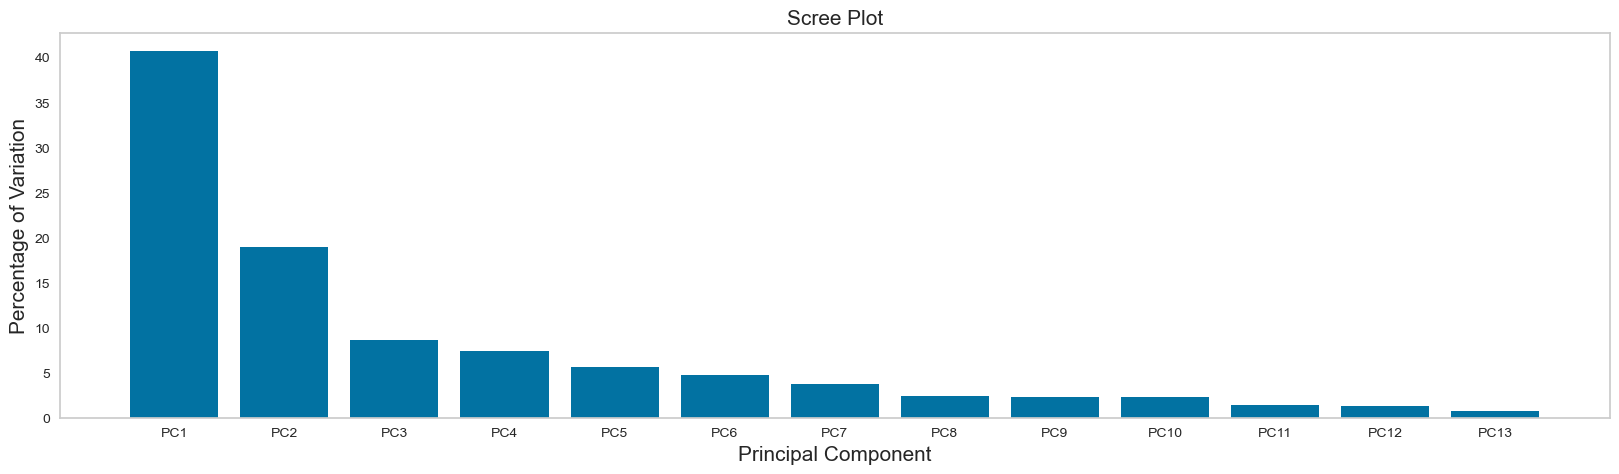

In [243]:
## Plot the best clustering solution using PCA
from sklearn.decomposition import PCA
pca = PCA().fit(X_scaled)  # scaled data preprocessed for k-Means, our current model choice
per_var = np.round(pca.explained_variance_ratio_*100, 1)  # to observe the most important features
print(f'\nThe most important features described by their explained variance ratios are ::\n'
      f'\t{per_var}\n')
plt.figure(figsize = (20,5))
princ_comp = ["PC" + str(x) for x in range(1, int(X.shape[1])+1)]
plt.bar(x = range(1, int(X.shape[1])+1), height = per_var, tick_label = princ_comp)
plt.xlabel("Principal Component", fontsize = 15)
plt.ylabel("Percentage of Variation", fontsize = 15)
plt.title("Scree Plot", fontsize = 15)
plt.grid();

In [280]:
col_to_keep = 3
retained_var = per_var[:col_to_keep+1]
print(f'\nBy keeping the first {col_to_keep} linear equations (principal components), we will retain ::\n'
      f'\t{retained_var.sum()}% of the total variation\n')


By keeping the first 3 linear equations (principal components), we will retain ::
	75.7% of the total variation



In [281]:
pd.DataFrame(data = pca.components_, columns = princ_comp, index = X.columns)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
Alcohol,-0.133368,0.248516,-0.000739,0.177839,-0.088657,-0.395071,-0.414590,0.333109,-0.252902,0.092329,-0.251137,-0.473492,-0.286862
Malic.acid,-0.550884,-0.227391,-0.163091,0.079776,-0.188166,-0.074145,-0.001007,-0.009960,-0.031418,-0.519707,0.237206,0.215562,-0.443888
Ash,-0.083848,0.492039,0.403009,0.477242,0.006551,0.253065,0.196105,0.285982,0.228342,-0.033100,-0.106589,0.297776,-0.151968
Acl,-0.040328,0.486032,-0.241976,-0.081694,0.015880,-0.052643,-0.027033,-0.709095,0.076574,-0.026322,-0.352498,0.082062,-0.229793
Mg,-0.278010,-0.412890,0.286394,0.418305,0.470899,-0.018030,0.002573,-0.360038,0.148666,0.200582,-0.077162,-0.263396,-0.076556
Phenols,-0.137254,-0.213103,-0.300965,-0.135610,-0.312519,0.283604,0.147045,0.197232,0.503115,0.388032,-0.283041,-0.167278,-0.276349
Flavanoids,-0.275352,0.310302,-0.171805,-0.297556,0.520419,-0.066524,-0.050698,0.214889,0.466207,-0.212596,0.193315,-0.224561,0.188372
Nonflavanoid.phenols,0.555031,-0.076928,-0.123460,0.270756,-0.019937,-0.413384,-0.156461,-0.034232,0.483470,-0.036924,0.295372,0.102303,-0.260229
Proanth,0.326687,-0.014471,-0.044362,-0.204924,0.471910,0.351232,0.088960,0.122889,-0.284054,-0.023708,0.068775,-0.060197,-0.624839
Color.int,-0.035912,-0.237073,-0.056899,-0.132503,0.325868,-0.263006,-0.199445,0.236775,0.018743,0.039143,-0.534248,0.602194,0.023829


In [282]:
pca_data = pca.transform(X_scaled)  # for plotting
pca_df = pd.DataFrame(pca_data, columns = princ_comp)
cols_to_drop = pca_df.columns[col_to_keep:] # perform the reduction
pca_df.drop([col for col in cols_to_drop], axis=1, inplace=True)
projected_data = pd.concat([pca_df, y], axis = 1)
projected_data

,PC1,PC2,PC3,Wine
0,-0.706336,-0.253193,0.024093,0
1,-0.484977,-0.008823,-0.280482,0
2,-0.521172,-0.189187,0.196217,0
3,-0.821644,-0.580906,0.081110,0
4,-0.202546,-0.059467,0.300240,0
...,...,...,...,...
173,0.739510,-0.471901,0.209360,2
174,0.581781,-0.348366,0.083590,2
175,0.626313,-0.546857,-0.030495,2
176,0.572991,-0.425516,-0.094537,2


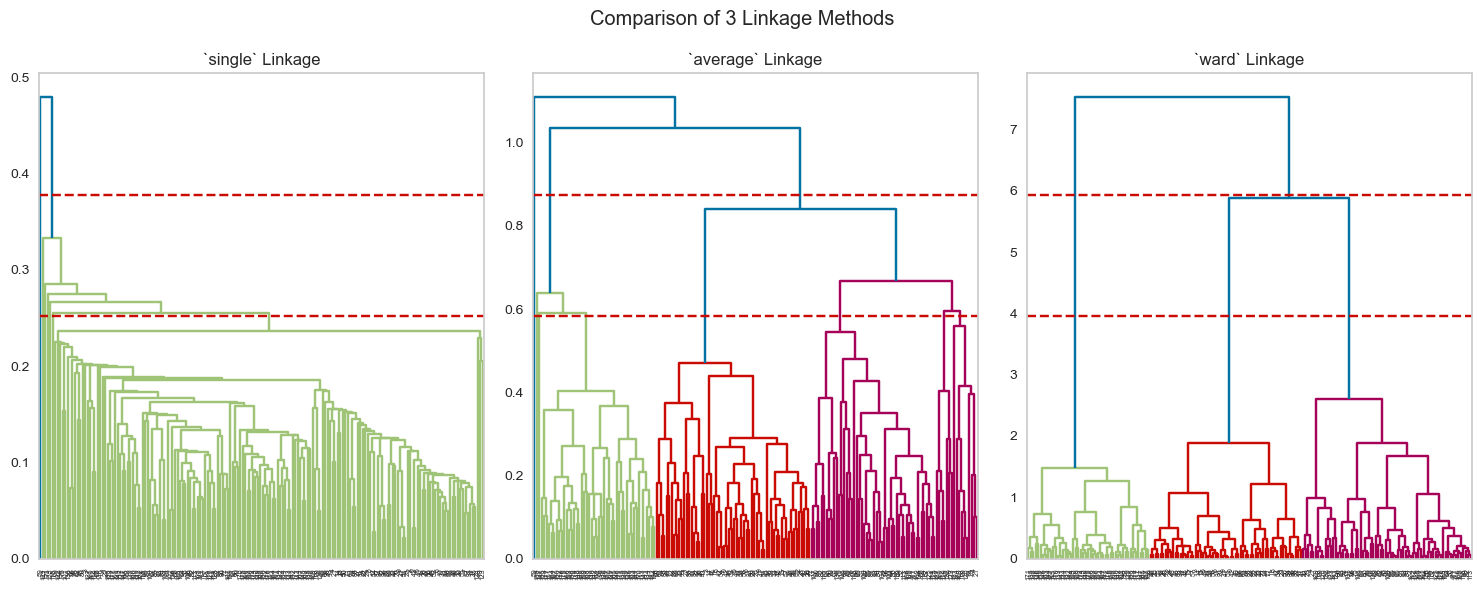

In [285]:
## We have to find the best 'k' with this new data to feed to our parameters
linkage_methods = ['single','average','ward'] # find the best linkage method
fig, axes = plt.subplots(1,3,figsize=(15,6))
for i, (ax, method) in enumerate(zip(axes, linkage_methods)):
    dendrogram(linkage(projected_data.iloc[:,:-1], method=method), ax=ax)
    ax.axhline(y=ax.get_ylim()[1]*.75, color='r', linestyle='--') # 3rd quartile
    ax.axhline(y=ax.get_ylim()[1]*.5, color='r', linestyle='--') # median
    ax.set_title(f'`{method}` Linkage')
    ax.grid();
plt.suptitle("Comparison of 3 Linkage Methods")
plt.tight_layout()
plt.show();

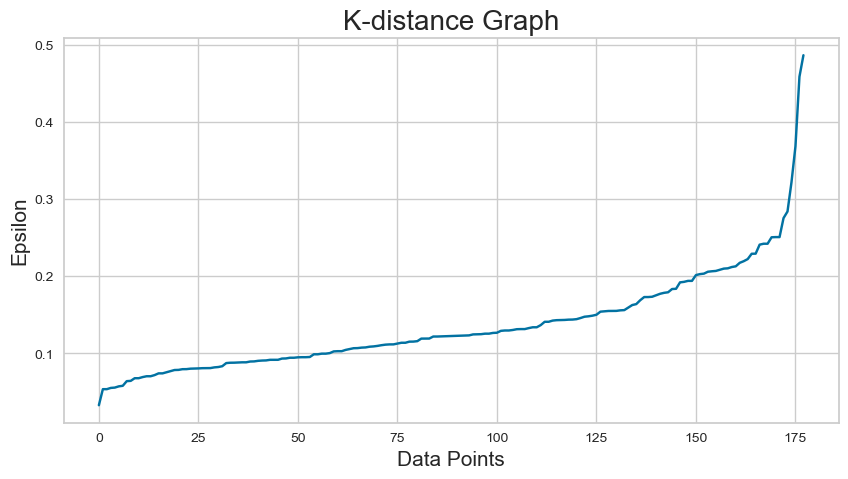

In [286]:
## DBSCAN gives me problems... find the new epsilon for this data
X_normalized2 = normalize(projected_data.iloc[:,:-1], norm='max', axis=1)
# 2- Find the optimal 'eps' value
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=min_samples_opt)
nbrs = neigh.fit(projected_data.iloc[:,:-1])
distances, indices = nbrs.kneighbors(projected_data.iloc[:,:-1])
dist = np.sort(distances[:,2])
plt.figure(figsize=(10,5))
plt.plot(dist)
plt.title("K-distance Graph",fontsize=20)
plt.xlabel("Data Points",fontsize=15)
plt.ylabel("Epsilon",fontsize=15);

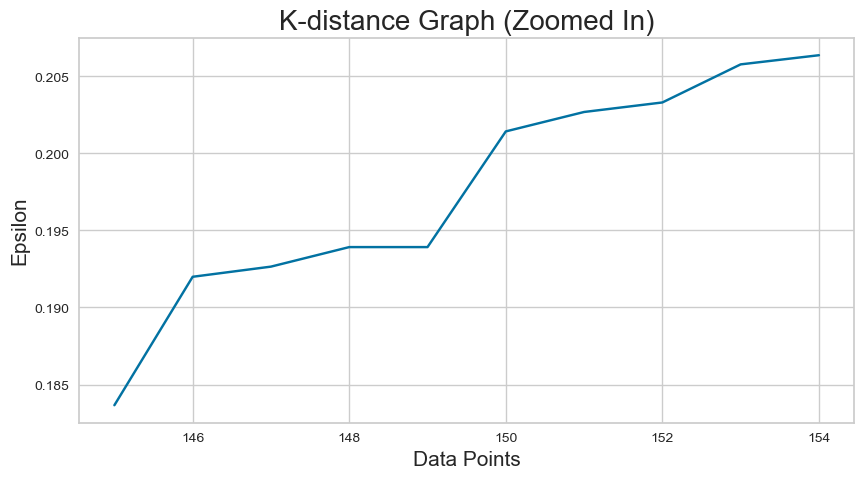

In [299]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(145,155), dist[145:155])  # zoom in on elbow
plt.title("K-distance Graph (Zoomed In)",fontsize=20)
plt.xlabel("Data Points",fontsize=15)
plt.ylabel("Epsilon",fontsize=15);

<br>

Now it's looking like we're still at $k=3$ based on our revised dendrogram and $\epsilon=0.192$ may be best!

In [311]:
set(db_model2.labels_)

{-1, 0, 1, 2}

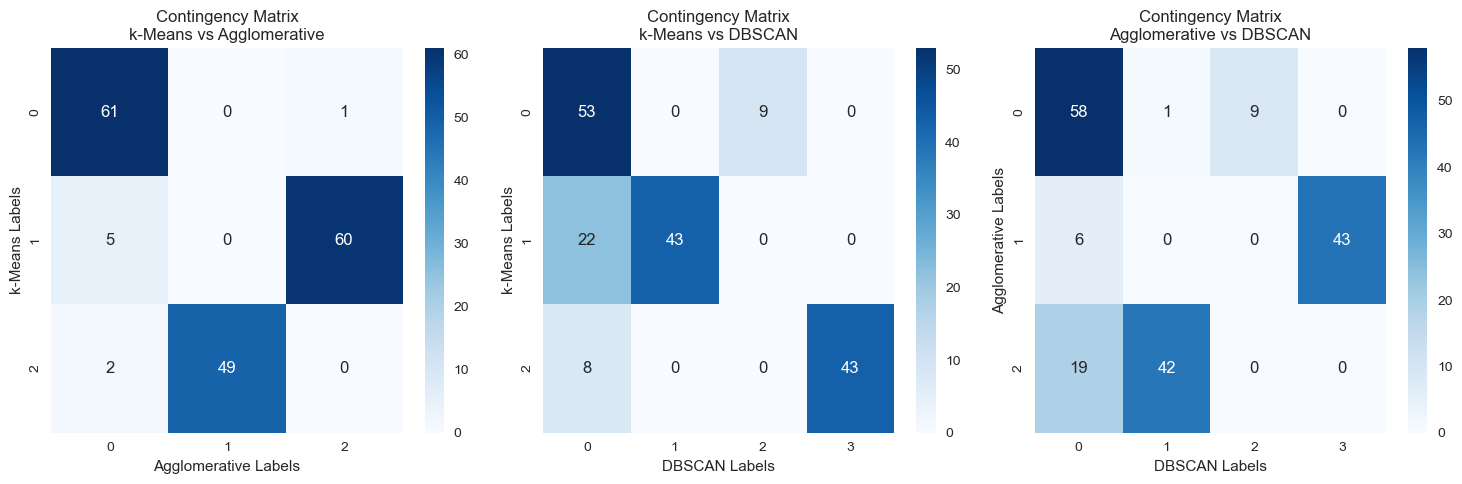

In [319]:
## Build one final model using reduced data
km_model2 = KMeans(n_clusters=k_opt).fit(projected_data.iloc[:,:-1])
agg_model2 = AgglomerativeClustering(n_clusters=k_opt, linkage='ward').fit(projected_data.iloc[:,:-1])
db_model2 = DBSCAN(eps=0.192, min_samples=min_samples_opt).fit(X_normalized2)

## Plot the best clustering solution in pairwise representation
db_labels2 = db_model2.labels_ + 1  # because of normalization
cm_km_agg2 = contingency_matrix(km_model2.labels_, agg_model2.labels_)
cm_km_db2 = contingency_matrix(km_model2.labels_, db_labels2)
cm_agg_db2 = contingency_matrix(agg_model2.labels_, db_labels2)
pred_labels2 = [km_model2.labels_, agg_model2.labels_, db_labels2]
cont_matrices2 = [cm_km_agg2, cm_km_db2, cm_agg_db2]
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, labels in enumerate(pred_labels2):
    if i==0: cont_mtx, mtx1, mtx2 = cont_matrices2[i], models[i], models[i+1]
    if i==1: cont_mtx, mtx1, mtx2 = cont_matrices2[i], models[i-1], models[i+1]
    if i==2: cont_mtx, mtx1, mtx2 = cont_matrices2[i], models[i-1], models[i]
    sns.heatmap(cont_mtx, annot=True, cmap='Blues', fmt='d', ax=axes[i])
    axes[i].set_title(f'Contingency Matrix\n{mtx1} vs {mtx2}')
    axes[i].set_xlabel(f'{mtx2} Labels')
    axes[i].set_ylabel(f'{mtx1} Labels')
plt.tight_layout()
plt.show();

--- 

<center><h2>4. Prediction</h2></center>

---

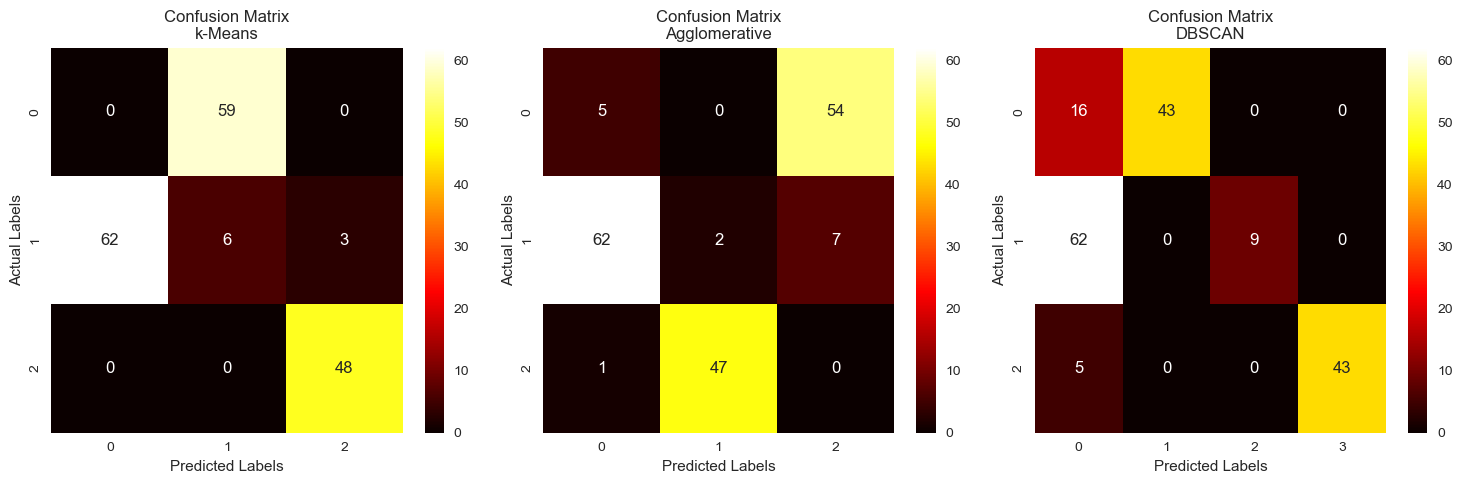

In [320]:
## Plot the best clustering solution in pairwise representation
pred_labels2 = [km_model2.labels_, agg_model2.labels_, db_labels2]
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, labels in enumerate(pred_labels2):     
    conf_mtx = contingency_matrix(y, labels)
    sns.heatmap(conf_mtx, annot=True, cmap='hot', fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix\n{models[i]}')
    axes[i].set_xlabel(f'Predicted Labels')
    axes[i].set_ylabel(f'Actual Labels')
plt.tight_layout()
plt.show();

<br>Now we have much fewer mistakes between all models, but `DBSCAN` still struggles to capture the labels the most using its density properties. This isn't surprising seeing how our `explained_variance_ratio` demonstrated little difference among many of the variables, and very few had near-no weight. In all, `kMeans` gave us just 9 misclassifications this time using PCA, and `AgglomerativeClustering` gave us 15. `DBSCAN` did not perform as poorly as previously, so we can see the powerful utility PCA has when coupled with algorithms like `DBSCAN`. It's clear that the nature of the data dictates the best algorithm for analysis and prediction.